Mounting Drive

In [72]:
# Loading your drive so CoLab has access to it
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verifying GPU Availability

In [73]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Constants

In [74]:
TEST_DIR = '/content/drive/MyDrive/ECE542\ Project\ Competition/data/TestData'
TRAIN_DIR = '/content/drive/MyDrive/ECE542\ Project\ Competition/data/TrainingData'

X_RATE = 40
Y_RATE = 10
NUM_SENSORS = 6

NUM_CLASSES = 4
MODEL = 'NN'
BAYESIAN = False
KFOLD_NUM = 5
PLOT_KFOLD = False
KFOLD = False
VERBOSE = 1
TENSORBOARD = False
# Types include 'TimeSeriesSplit', 'KFold', and 'SubjectFold'
KFOLD_TYPE = 'KFold'
CLASS_WEIGHTS = True
WHOSE_MODEL = 'Tyrone'
MODEL_CHECKPOINTING = True
CHECKPOINT_OUT_DIR = "/content/drive/MyDrive/ECE542 Project Competition/data/Checkpoints/" + str(uuid4())
print("Saving Checkpointed Models to:\n" + CHECKPOINT_OUT_DIR)

# CAN BE OPTIMIZED
#EPOCHS = 50
if (WHOSE_MODEL == 'Tyrone'):
  EPOCHS = 50 # Tyrones Model
elif (WHOSE_MODEL == 'Tyroneee'):
  EPOCHS = 50
elif (WHOSE_MODEL == 'Matt'):
  EPOCHS = 100

BATCH_SIZE = 32
LSTM_UNITS = 256
DROPOUT_1 = 0.3
DENSE_1 = 64
DROPOUT_2 = 0.3
if (WHOSE_MODEL == 'Tyrone'):
  INIT_LR = 0.001 # Tyrones Model
elif (WHOSE_MODEL == 'Tyroneee'):
  INIT_LR = 0.0007
elif (WHOSE_MODEL == 'Matt'):
  INIT_LR = 0.00001
X_TIME_WINDOW = 2
Y_TIME_STEP_SIZE = 0.5
LOWPASS_FILTER = False

Warnings Were Annoying Me


In [75]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Locate Data Directory

In [76]:
%cd $TRAIN_DIR

/content/drive/.shortcut-targets-by-id/1t9L_g0-QFmUyGlCvXp78mnRHrQ9HnqTI/ECE542 Project Competition/data/TrainingData


Loading Data

In [77]:
import pandas as pd
import numpy as np

def load_data(Subject=1, Trial=1, load_Y=True, verbose=0):
  X_DATA_TIME_FORMAT = 'subject_{:03d}_{:02d}__x_time.csv'.format(Subject, Trial)
  X_DATA_FORMAT = 'subject_{:03d}_{:02d}__x.csv'.format(Subject, Trial)
  if (load_Y):
    Y_DATA_TIME_FORMAT = 'subject_{:03d}_{:02d}__y_time.csv'.format(Subject, Trial)
    Y_DATA_FORMAT = 'subject_{:03d}_{:02d}__y.csv'.format(Subject, Trial)

  if (verbose):
    print(X_DATA_TIME_FORMAT)
    print(X_DATA_FORMAT)
    if (load_Y):
      print(Y_DATA_TIME_FORMAT)
      print(Y_DATA_FORMAT)

  x_time = pd.read_csv(X_DATA_TIME_FORMAT, names=['sec'])
  x_data = pd.read_csv(X_DATA_FORMAT, names=['x accelerometer', 'y accelerometer', 'z accelerometer', 'x gyroscope', 'y gyroscope', 'z gyroscope'])
  if (load_Y):
    y_time = pd.read_csv(Y_DATA_TIME_FORMAT, names=['sec'])
    y_data = pd.read_csv(Y_DATA_FORMAT, names=['label'])

  if (LOWPASS_FILTER):
    x_data = butter_lowpass_filtfilt(x_data)
    
  if (load_Y):
    return x_time, x_data, y_time, y_data;
  return x_time, x_data

Format Data Function

This function takes in a series of y_time values, y_data values, x_time, and x_data and prepares is as a set of X and Y data arrays, where X is the data in the form of a time window prior to a label, where the label is stored in Y


In [78]:
def format_data(x_time, x_data, y_time=None, y_data=None, X_Time_Window=1, Y_Time_Step_Size=1, verbose=0):

  format_Y = (y_time is not None and y_data is not None)

  # Combining time and data DataFrames
  if (format_Y):
    y_full = pd.concat([y_time, y_data], axis=1)
  x_full = pd.concat([x_time, x_data], axis=1)

  # Determine the start index and time for the X Data Samples
  X_Start_Index = X_Time_Window*X_RATE
  X_Start_Time = x_full.iloc[X_Start_Index]['sec']

  # Determine the Y Starting index as being the first sample where the time is greater than the X start time
  if (format_Y):
    Y_Start_Index = 0
    while (y_full.iloc[Y_Start_Index]['sec'] < X_Start_Time):
      Y_Start_Index += 1

    # Getting Y Start Time
    Y_Start_Time = y_full.iloc[Y_Start_Index]['sec']

    # Calculating the Y End Index and Time by finding the first Y location where there is a regular increment of step size to reach
    Y_End_Index = -1
    # Comparison is to resolve floating point accuracy errors
    while ((y_full.iloc[Y_End_Index]['sec'] - Y_Start_Time) % Y_Time_Step_Size > 0.001):
      Y_End_Index -= 1

    # Getting Y End Time
    Y_End_Time = y_full.iloc[Y_End_Index]['sec']

    # Getting the number of data points that will be created
    Num_Data_Points = int((Y_End_Time - Y_Start_Time)/Y_Time_Step_Size)

  else:
    Num_Data_Points = int((x_full.iloc[-1]['sec'] - X_Start_Time)/Y_Time_Step_Size)

  if (verbose):
    print("Constructing", Num_Data_Points, "Data Points")

  # Initializing empty numpy arrays, different shapes for different models
  if (MODEL == 'SVM' or MODEL == 'RFC'):
    X = np.zeros((Num_Data_Points, X_Time_Window*X_RATE*NUM_SENSORS))
    if (format_Y):
      Y = np.zeros((Num_Data_Points))
  elif (MODEL == 'NN' or MODEL == 'CNN'):
    X = np.zeros((Num_Data_Points, X_Time_Window*X_RATE, NUM_SENSORS))
    if (format_Y):
      Y = np.zeros((Num_Data_Points, NUM_CLASSES))

  # Starting Data Slices
  if (format_Y):
    Y_Cur_Index = Y_Start_Index
  X_Cur_Index = X_Start_Index
  for epoch in range(Num_Data_Points):
    # Formatting data, grabbing a slice around the Index that corresponds to the current Y Label being extracted
    # Slicing the array, dropping the 'sec' column, converting to a numpy array, the astype part is housekeeping, makes TensorFlow happier
    # Flattening the array takes, for example, (40, 6) shape and makes it (240, 1)
    if (MODEL == 'SVM' or MODEL == 'RFC'):
      X[epoch] = np.array(x_full.iloc[X_Cur_Index-X_Time_Window*X_RATE:X_Cur_Index].drop('sec', axis=1)).astype(np.float64).flatten()
    elif (MODEL == 'NN' or MODEL == 'CNN'):
      X[epoch] = np.array(x_full.iloc[X_Cur_Index-X_Time_Window*X_RATE:X_Cur_Index].drop('sec', axis=1)).astype(np.float64)

    if (format_Y):
      # SVMs and RFCs take a label
      if (MODEL == 'SVM' or MODEL == 'RFC'):
        Y[epoch] = y_full.iloc[Y_Cur_Index]['label']

      # Neural networks get one hot encoding
      elif (MODEL == 'NN' or MODEL == 'CNN'):
        Y[epoch][int(y_full.iloc[Y_Cur_Index]['label'])] = 1

      # Incrementing the current indices by the step size
      Y_Cur_Index += int(Y_Time_Step_Size*Y_RATE)
    X_Cur_Index += int(Y_Time_Step_Size*X_RATE)

  if (format_Y):
    return X, Y
  return X

In [79]:
def swap_label(labels):
    y_multi = np.copy(labels)
    for label in y_multi:
        if label[1] == 1:
            label[1] = 0
            label[3] = 1
        elif label[3] == 1:
            label[3] = 0
            label[1] = 1
    return y_multi

Function call and data formatting


In [80]:
X_Time_Window = X_TIME_WINDOW
Y_Time_Step_Size = Y_TIME_STEP_SIZE

Subject_Trials = ((1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (1, 3), (2, 3), (3, 3), (5, 3), (6, 3), (7, 3), (1, 4), (2, 4), (7, 4), (1, 5), (2, 5), (1, 6), (1, 7), (1, 8))
#Subject_Trials = ((2, 1),)

if (not KFOLD or KFOLD_TYPE == 'TimeSeriesSplit' or KFOLD_TYPE == 'KFold'):
  X, Y = None, None
  for (Subject, Trial) in Subject_Trials:
    x_time, x_data, y_time, y_data = load_data(Subject, Trial)

    X_tmp, Y_tmp = format_data(x_time, x_data, y_time, y_data, X_Time_Window, Y_Time_Step_Size)
    if (X is None and Y is None):
      X = X_tmp
      Y = Y_tmp
    else:
      X = np.concatenate((X, X_tmp))
      Y = np.concatenate((Y, Y_tmp))

  if (MODEL == 'CNN'):
    X = np.transpose(X, axes=(0, 2, 1))
elif (KFOLD_TYPE == 'SubjectFold'):
  X, Y = {}, {}
  for (Subject, Trial) in Subject_Trials:
    x_time, x_data, y_time, y_data = load_data(Subject, Trial)

    X_tmp, Y_tmp = format_data(x_time, x_data, y_time, y_data, X_Time_Window, Y_Time_Step_Size)
    if (Subject not in X):
      X[Subject] = X_tmp
      Y[Subject] = Y_tmp
    else:
      X[Subject] = np.concatenate((X[Subject], X_tmp))
      Y[Subject] = np.concatenate((Y[Subject], Y_tmp))

if (WHOSE_MODEL == 'Tyroneee'):
  Y = swap_label(Y)

Check Data Label Distribution

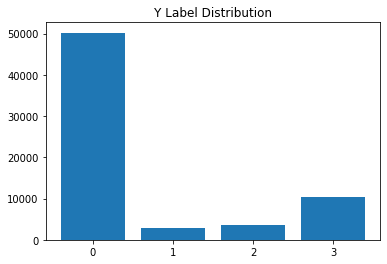

(66947, 4)


In [81]:
import matplotlib.pyplot as plt

def check_label_distribution(Y):
  if (MODEL == 'SVM' or MODEL == 'RFC'):
    (unique, counts) = np.unique(Y, return_counts=True)
    x_labels = [str(int(val)) for val in unique]
  elif (MODEL == 'NN' or MODEL == 'CNN'):
    counts = sum(Y)
    x_labels = [str(val) for val in range(NUM_CLASSES)]

  plt.bar(x_labels, counts)  # arguments are passed to plt.bar
  plt.title("Y Label Distribution")
  plt.show()

if (KFOLD_TYPE != 'SubjectFold'):
  check_label_distribution(Y)
  print(Y.shape)

Handle Class Imbalance

In [82]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def handle_imbalance(X, Y):
  over = SMOTE()
  under = RandomUnderSampler()
  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  X_sm, Y_sm = pipeline.fit_resample(X, Y)
  return X_sm, Y_sm

Training Loss Visualization


In [83]:
from tensorflow import keras
from IPython.display import clear_output
# updatable plot
# a minimal example (sort of)

# From https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Tensorboard Callback


In [84]:
from tensorboard.plugins.hparams import api as hp
import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
#hparams_callback = hp.KerasCallback(log_dir, {
#    'num_relu_units': 512,
#    'dropout': 0.2
#})

Preparing Model


SVM

In [85]:
try: 
  from skopt.space import Real, Categorical, Integer
except ModuleNotFoundError:
  !pip install scikit-optimize
  from skopt.space import Real, Categorical, Integer


In [86]:
# define the space of hyperparameters to search
search_space_svm = {}
search_space_svm['C'] = Real(1e-6, 100.0, 'log-uniform')
search_space_svm['kernel'] = Categorical(['linear', 'poly', 'rbf', 'sigmoid'])
search_space_svm['degree'] = Integer(1, 5)
search_space_svm['gamma'] = Real(1e-6, 100.0, 'log-uniform')

RFC


In [87]:
search_space_rfc = {}
search_space_rfc['n_estimators'] = Integer(100, 2000)
search_space_rfc['max_depth'] = Integer(10, 100)
search_space_rfc['max_features'] = Categorical(['auto', 'sqrt'])
search_space_rfc['bootstrap'] = Categorical([True, False])
search_space_rfc['min_samples_leaf'] = Integer(1, 5)
search_space_rfc['min_samples_split'] = Integer(2, 10)

Neural Net

In [88]:
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, make_scorer

def build_model_nn(P1=LSTM_UNITS, P2=DROPOUT_1, P3=DENSE_1, P4=DROPOUT_2, lr=INIT_LR):
  if (WHOSE_MODEL == 'Matt'):
    model = keras.Sequential([
        tf.compat.v1.keras.layers.CuDNNLSTM(units=P1), # P1 = 256
        keras.layers.Dropout(rate=P2),
        keras.layers.Dense(units=P3, activation='relu'),
        keras.layers.Dropout(rate=P4),
        keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
    ])
  elif (WHOSE_MODEL == 'Tyrone'):
    model = keras.Sequential([
        tf.compat.v1.keras.layers.CuDNNLSTM(units=256),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(units=256),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
    ])
  elif (WHOSE_MODEL == 'Tyroneee'):
    window_input = keras.Input(shape=(80, 6), name="window_input")

    layer1 = tf.compat.v1.keras.layers.CuDNNLSTM(units=384, return_sequences=False, name='lstm_layer1')(window_input)
    layer1 = keras.layers.BatchNormalization()(layer1)

    # Path for Standing/Grass
    layer21 = keras.layers.Dense(units=256, activation='relu', name='dense_layer21')(layer1)
    layer21 = keras.layers.BatchNormalization()(layer21)
    layer21 = keras.layers.Dropout(rate=0.5)(layer21)

    layer31 = keras.layers.Dense(units=128, activation='relu', name='dense_layer31')(layer21)
    layer31 = keras.layers.BatchNormalization()(layer31)
    layer31 = keras.layers.Dropout(rate=0.4)(layer31)

    layer41 = keras.layers.Dense(units=64, activation='relu', name='dense_layer41')(layer31)
    layer41 = keras.layers.BatchNormalization()(layer41)
    layer41 = keras.layers.Dropout(rate=0.3)(layer41)

    layer51 = keras.layers.Dense(units=32, activation='relu', name='dense_layer51')(layer41)
    layer51 = keras.layers.BatchNormalization()(layer51)
    layer51 = keras.layers.Dropout(rate=0.2)(layer51)

    layer61 = keras.layers.Dense(units=16, activation='relu', name='dense_layer61')(layer51)
    layer61 = keras.layers.BatchNormalization()(layer61)
    layer61 = keras.layers.Dropout(rate=0.1)(layer61)

    layer71 = keras.layers.Dense(units=4, activation='relu', name='dense_layer71')(layer61)
    layer71 = keras.layers.BatchNormalization()(layer71)

    layer81 = keras.layers.Dense(units=2, name='dense_layer81')(layer71)

    # Path for Stairs
    layer22 = keras.layers.Dense(units=128, activation='relu', name='dense_layer22')(layer1)
    layer22 = keras.layers.BatchNormalization()(layer22)
    layer22 = keras.layers.Dropout(rate=0.4)(layer22)

    layer32 = keras.layers.Dense(units=2, name='dense_layer42')(layer22)

    # Combine
    out = keras.layers.concatenate([layer81, layer32])
    out = keras.layers.Softmax()(out)

    model = keras.Model(inputs=window_input, outputs=out)

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

search_space_nn = {}
search_space_nn['P1'] = Integer(1, 512)
search_space_nn['P2'] = Real(0, 1)
search_space_nn['P3'] = Integer(1, 512)
search_space_nn['P4'] = Real(0, 1)
search_space_nn['lr'] = Real(1e-6, 1)

CNN (Based on Team 7)


In [89]:
def build_model_cnn():
  model = keras.Sequential([
      keras.layers.Input(shape=(1, 6, 120)),
      keras.layers.Conv1D(12, kernel_size=9, strides=1, activation='relu'),
      keras.layers.AveragePooling1D(pool_size=3, strides=1),
      keras.layers.Conv1D(6, kernel_size=9, strides=1, activation='relu'),
      keras.layers.AveragePooling1D(pool_size=3, strides=3),
      keras.layers.Flatten(),
      keras.layers.Dense(128),
      keras.layers.Dense(4, activation='softmax')
  ])

  opt = keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [90]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split

if (MODEL == 'SVM'):
  model = svm.SVC(C = 7, degree=3, gamma=5)
elif (MODEL == 'NN'):
  model = build_model_nn()
elif (MODEL == 'CNN'):
  model = build_model_cnn()
elif (MODEL == 'RFC'):
  model = RFC(max_features='sqrt', max_depth=20)

Bayesian Tuning

In [91]:
from skopt import BayesSearchCV

if (BAYESIAN):
  if (MODEL == 'SVM'):
    model_bayes = svm.SVC()
    model_search_space = search_space_svm
  elif (MODEL == 'RFC'):
    model_bayes = RFC()
    model_search_space = search_space_rfc
  elif (MODEL == 'NN'):
    model_bayes = keras.wrappers.scikit_learn.KerasClassifier(build_model_nn, verbose=0)
    model_search_space = search_space_nn
  elif (MODEL == 'CNN'):
    raise Exception("Currently unimplemented")

  def on_step(optim_result):
    score = searcher.best_score_
    print("Best Score: {score:.2%}".format(score=score))
    if (score >= 0.9):
      print("Interrupting!")
      return True

  f1 = make_scorer(f1_score , average='weighted')

  searcher = BayesSearchCV(model_bayes, model_search_space, n_iter=32, scoring=f1)

  searcher.fit(X_train, Y_train, callback=on_step)

  print(f"Validation Score: {searcher.best_score_}")
  print(f"Test Score: {searcher.score(X_test, Y_test)}")
  print(f"Best Parameters: {str(searcher.best_params_)}")

Custom Subject Fold Class


In [92]:
class SubjectFold():
  def __init__(self, X, Y):
    self.X = None
    self.Y = None
    self.slices = {}
    self.keys = list(X.keys())
    for item in X:
      if (self.X is None):
        self.X = X[item]
        self.Y = Y[item]
        self.slices[item] = (0, X[item].shape[0])
      else:
        self.slices[item] = (self.X.shape[0], self.X.shape[0]+X[item].shape[0])
        self.X = np.concatenate((self.X, X[item]))
        self.Y = np.concatenate((self.Y, Y[item]))

  def __iter__(self):
    self.n = 0
    return self
  
  def __next__(self):
    if (self.n < len(self.keys)):
      key = self.keys[self.n]
      slices = self.slices[key]
      self.n += 1
      X_test = self.X[slices[0]:slices[1]]
      Y_test = self.Y[slices[0]:slices[1]]
      X_train = np.concatenate((self.X[:slices[0]], self.X[slices[1]:]))
      Y_train = np.concatenate((self.Y[:slices[0]], self.Y[slices[1]:]))
      return key, X_train, X_test, Y_train, Y_test
    else:
      raise StopIteration

ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_OUT_DIR, verbose=VERBOSE, save_best_only=True, save_weights_only=True)


Fitting Model

(11593, 80, 6)
(11593, 4)
Epoch 1/50
363/363 [==============================] - 12s 29ms/step - loss: 1.5914 - accuracy: 0.6751 - val_loss: 0.4453 - val_accuracy: 0.8551
Epoch 2/50
363/363 [==============================] - 10s 28ms/step - loss: 0.7748 - accuracy: 0.8477 - val_loss: 0.5222 - val_accuracy: 0.8141
Epoch 3/50
363/363 [==============================] - 10s 29ms/step - loss: 0.5956 - accuracy: 0.8758 - val_loss: 0.3424 - val_accuracy: 0.8855
Epoch 4/50
363/363 [==============================] - 10s 29ms/step - loss: 0.5828 - accuracy: 0.8877 - val_loss: 0.4483 - val_accuracy: 0.8462
Epoch 5/50
363/363 [==============================] - 10s 28ms/step - loss: 0.4730 - accuracy: 0.9036 - val_loss: 0.4160 - val_accuracy: 0.8793
Epoch 6/50
363/363 [==============================] - 10s 28ms/step - loss: 0.4280 - accuracy: 0.9129 - val_loss: 0.4228 - val_accuracy: 0.8468
Epoch 7/50
363/363 [==============================] - 10s 27ms/step - loss: 0.3980 - accuracy: 0.9159 - val_lo

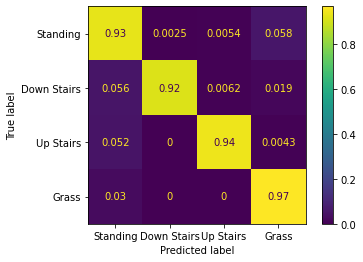

In [93]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight

class_weights = {0:1, 1:4, 2:4, 3:6}
if (WHOSE_MODEL == 'Tyroneee'):
  class_weights = {0:1, 1:6, 2:4, 3:4}

"""
if (MODEL_TYPE != 'SVM'):
  Y_ints = np.argmax(Y_train, axis=1)
  class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(Y_ints), Y_ints)))
else:
  class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
"""

if (KFOLD and KFOLD_TYPE == 'TimeSeriesSplit'):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)#, random_state=42, stratify=Y)
  #Y_ints = np.argmax(Y_train, axis=1)
  #class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(Y_ints), Y_ints)))
  kfold = TimeSeriesSplit(n_splits=KFOLD_NUM)
elif (KFOLD and KFOLD_TYPE == 'KFold'):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)#, random_state=42, stratify=Y)
  #Y_ints = np.argmax(Y_train, axis=1)
  #class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(Y_ints), Y_ints)))
  kfold = KFold(n_splits=KFOLD_NUM)
elif (KFOLD and KFOLD_TYPE == 'SubjectFold'):
  kfold = SubjectFold(X, Y)
acc_per_fold = []
display_labels=['Standing','Down Stairs','Up Stairs','Grass']
if (WHOSE_MODEL == 'Tyroneee'):
  display_labels=['Standing','Grass','Up Stairs','Down Stairs']

if (MODEL == 'SVM' or MODEL == 'RFC'):
  X_train, Y_train = handle_imbalance(X_train, Y_train)
  model.fit(X_train, Y_train)
elif (MODEL == 'NN' or MODEL == 'CNN'):
  if (KFOLD):
    if (KFOLD_TYPE == 'KFold' or KFOLD_TYPE == 'TimeSeriesSplit'):
      current_fold = 1
      for train, test in kfold.split(X_train, Y_train):
        print("Performing KFold Number {}".format(current_fold))
        X_fold_train, X_fold_val, Y_fold_train, Y_fold_val = train_test_split(X_train[train], Y_train[train], test_size=0.2)#, random_state=42, stratify=Y_train)

        if (MODEL == 'NN'):
          model = build_model_nn()
          model.fit(X_fold_train, Y_fold_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, Y_fold_val), verbose=VERBOSE, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback]))
        elif (MODEL == 'CNN'):
          model = build_model_cnn()
          model.fit(X_fold_train, Y_fold_train, epochs=EPOCHS, batch_size=64, validation_data=(X_fold_val, Y_fold_val), verbose=VERBOSE, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback]))
        
        Yhat_train_test = model.predict(X_train[test])

        Yhat_train_test=np.argmax(Yhat_train_test, axis=1)
        Y_train_test=np.argmax(Y_train[test], axis=1)

        fold_acc = f1_score(Y_train_test,Yhat_train_test, average='macro')

        print("Acc: {:.2%}".format(fold_acc))

        acc_per_fold.append(fold_acc)

        #if current_fold == KFOLD_NUM:
          #print("Performance in k fold {}".format(current_fold))
          #print(classification_report(Y_train_test, Yhat_train_test, target_names=display_labels))

          # Plotting confusion matrix
          #cm = confusion_matrix(Y_train_test,Yhat_train_test,normalize='true')
          #per_class_accuracy = cm.diagonal()/cm.sum(axis=1)
          #print("per_class_accuracy")
          #print(per_class_accuracy)
          #print("Overall Accuracy")
          #print(accuracy_score(Y_train_test,Yhat_train_test))
          # disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
          # disp.plot()
        current_fold += 1
      
      acc = np.mean(acc_per_fold)

      print("KFold Results:")
      print("Acc: {:.2%}".format(acc))
    elif (KFOLD_TYPE == 'SubjectFold'):
      for key, X_train, X_test, Y_train, Y_test in kfold:
        print("Performing KFold for Subject {}".format(key))

        #Y_ints = np.argmax(Y_train, axis=1)
        #class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(Y_ints), Y_ints)))

        X_fold_train, X_fold_val, Y_fold_train, Y_fold_val = train_test_split(X_train, Y_train, test_size=0.2)

        if (MODEL == 'NN'):
          model = build_model_nn()
          model.fit(X_fold_train, Y_fold_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, Y_fold_val), verbose=0, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback]))
        elif (MODEL == 'CNN'):
          model = build_model_cnn()
          model.fit(X_fold_train, Y_fold_train, epochs=EPOCHS, batch_size=64, validation_data=(X_fold_val, Y_fold_val), verbose=0, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback]))

        Yhat_train_test = model.predict(X_test)

        Yhat_train_test=np.argmax(Yhat_train_test, axis=1)
        Y_train_test=np.argmax(Y_test, axis=1)

        fold_acc = f1_score(Y_train_test, Yhat_train_test, average='macro')

        print("Acc for Subject {}: {:.2%}".format(key, fold_acc))

        acc_per_fold.append(fold_acc)
      
      acc = np.mean(acc_per_fold)

      print("KFold Results:")
      print("Acc: {:.2%}".format(acc))
  else:
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    
    print(X_train.shape)
    print(Y_train.shape)

    if (MODEL == 'NN'):
      model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), verbose=VERBOSE, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback, ModelCheckpointCallback]))
    elif (MODEL == 'CNN'):
      model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=64, validation_data=(X_val, Y_val), verbose=VERBOSE, class_weight=(class_weights if CLASS_WEIGHTS else None), callbacks=([plot_losses, tensorboard_callback] if KFOLD and PLOT_KFOLD else [tensorboard_callback, ModelCheckpointCallback]))


Yhat_train = model.predict(X_train)

if (MODEL == 'NN' or MODEL == 'CNN'):
  Yhat_train_cf=np.argmax(Yhat_train, axis=1)
  Y_train_cf=np.argmax(Y_train, axis=1)
elif (MODEL == 'SVM' or MODEL == 'RFC'):
  Yhat_train_cf = Yhat_train
  Y_train_cf = Y_train

if (MODEL_CHECKPOINTING):
  model.load_weights(CHECKPOINT_OUT_DIR)

#print("Final results on 80-20 split data:")

print('Train Accuracy = {score:.2%}'.format(score=f1_score(Y_train_cf,Yhat_train_cf, average='macro')))
Yhat_test = model.predict(X_test)

if (MODEL == 'NN' or MODEL == 'CNN'):
  Yhat_test_cf=np.argmax(Yhat_test, axis=1)
  Y_test_cf=np.argmax(Y_test, axis=1)
elif (MODEL == 'SVM' or MODEL == 'RFC'):
  Yhat_test_cf = Yhat_test
  Y_test_cf = Y_test

print('Test Accuracy = {score:.2%}'.format(score=f1_score(Y_test_cf,Yhat_test_cf, average='macro')))

#print(classification_report(Y_test_cf, Yhat_test_cf, target_names=display_labels))

# Plotting confusion matrix
cm = confusion_matrix(Y_test_cf,Yhat_test_cf,normalize='true')
#per_class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("per_class_accuracy")
#print(per_class_accuracy)
#print("Overall Accuracy")
#print(accuracy_score(Y_test_cf,Yhat_test_cf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
disp.plot()

Move to the Test Data Directory


In [94]:
%cd $TEST_DIR

/content/drive/.shortcut-targets-by-id/1t9L_g0-QFmUyGlCvXp78mnRHrQ9HnqTI/ECE542 Project Competition/data/TestData


Training model of the full dataset

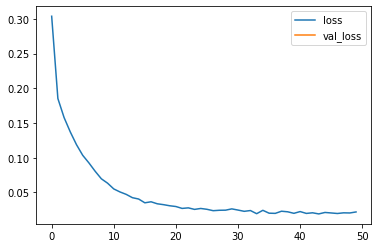

In [ ]:
model = build_model_nn()

model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[plot_losses, tensorboard_callback])

Constructing Label Predictions

In [ ]:
SUBJECT_TRIAL_NUMS = ((9, 1), (10, 1), (11, 1), (12, 1))

for (Subject, Trial) in SUBJECT_TRIAL_NUMS:
  x_time, x_data = load_data(Subject, Trial, False)

  X = format_data(x_time, x_data, X_Time_Window=X_Time_Window, Y_Time_Step_Size=Y_Time_Step_Size)

  Y = model.predict(X)
  Y = [np.argmax(Y[i]) for i in range(len(Y))]

  Expected_Len = int(x_time.iloc[-1]['sec']*10 - 0.01)

  Expanded_Y = []

  for i in range(int(X_Time_Window*Y_RATE)):
    Expanded_Y.append(Y[0])

  for i in range(1, len(Y)):
    for j in range(int(Y_Time_Step_Size*Y_RATE)):
      Expanded_Y.append(Y[i])

  if (len(Expanded_Y) < Expected_Len):
    while (len(Expanded_Y) != Expected_Len):
      Expanded_Y.append(Expanded_Y[-1])

  print(len(Expanded_Y))
  (unique, counts) = np.unique(Expanded_Y, return_counts=True)
  x_labels = [str(int(val)) for val in unique]  

  plt.bar(x_labels, counts)  # arguments are passed to np.bar
  plt.title("Y Label Distribution")
  plt.show()

  pd_df = pd.DataFrame(Expanded_Y)

  Y_Data_Filename = 'LabelPredictions/subject_{:03d}_{:02d}__y.csv'.format(Subject, Trial)

  pd_df.to_csv(Y_Data_Filename, index=False)

Model Visualization


In [ ]:
%cd $TRAIN_DIR

/content/drive/.shortcut-targets-by-id/1t9L_g0-QFmUyGlCvXp78mnRHrQ9HnqTI/ECE542 Project Competition/data/TrainingData


In [ ]:
if (TENSORBOARD):
  !tensorboard dev upload --logdir ./logs \
    --name "ECE542 - Project Competition" \
    --description "Testing usage of TensorBoard on the ECE542 Competition Project" \
    --one_shot